# Portfolio analysis

## Case II : Stock prices from FTSE100 Index

In [59]:
library('dplyr')
library('tidyverse')
library('Sim.DiffProc')
library('quadprog')
library('ggplot2')
library('plotly')
options(repr.plot.width=16, repr.plot.height=8)

In [60]:
source('./PortfolioFunctions_v1.r')

In [97]:
stock_prices <- read.csv('./df_FTSE100.csv')%>%
  mutate(Date=as.Date(Date,format = "%d/%m/%Y"))
head(stock_prices)

,Date,RMV.L,AHT.L,EXPN.L,RTO.L,ABF.L,STJ.L,BATS.L,PRU.L,GVC.L,...,SPX.L,SSE.L,BA.L,VOD.L,SDR.L,SLA.L,RB.L,TSCO.L,RR.L,ANTO.L
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2008-01-03,47.625,80.75,402.75,118.9,873.0,273.041,1974,714.5,98.5,...,950.923,1657,497.0,194.139,1253,312.583,2828.60,468.00,537.0,717.0
2,2008-01-04,45.600,79.75,395.25,117.0,831.5,256.007,1959,685.5,101.0,...,928.846,1635,479.0,193.722,1202,301.583,2783.64,456.00,528.0,688.0
3,2008-01-07,44.300,77.50,392.25,112.9,834.0,258.969,1969,689.5,101.0,...,899.231,1668,480.0,196.120,1126,297.611,2808.07,445.50,511.0,668.5
4,2008-01-08,45.300,76.00,396.50,114.6,826.5,248.601,1968,671.0,104.5,...,910.000,1667,492.0,199.769,1133,292.111,2779.73,442.00,516.5,672.0
5,2008-01-09,42.500,73.00,372.75,107.9,789.5,240.207,2007,687.5,105.0,...,888.462,1659,507.0,196.120,1113,282.333,2775.82,418.75,528.0,645.0
6,2008-01-10,42.875,72.00,361.75,106.0,801.0,235.023,2049,673.0,105.0,...,910.000,1679,493.5,196.745,1100,275.000,2687.85,416.25,525.0,644.5


In [98]:
# get portfolio MV model
port.mv <- getPortfolio(base=stock_prices,year_to_start='2013',rebalance_period=24,mod='mv')

Estimated period : 2013-01 
Estimated period : 2015-01 
Estimated period : 2017-01 
Estimated period : 2019-01 
Estimated period : 2021-01 


In [99]:
# get portfolio MV-GBM model
port.mv_gbm <- getPortfolio(base=stock_prices,year_to_start='2013',rebalance_period=24,mod='gbm')

Estimated period : 2013-01 
Estimated period : 2015-01 
Estimated period : 2017-01 
Estimated period : 2019-01 
Estimated period : 2021-01 


In [100]:
#  Portfolio return
names <- c('date','MV','MV-GBM','MV-EW','MV-RW')
portfolio.ret <- data.frame('date' = port.mv$df.port.ret$date,
                       'MV'= port.mv$df.port.ret$min.ret,
                       'MV.GBM'= port.mv_gbm$df.port.ret$min.ret,
                       'MV.EW' = port.mv$df.port.ret$eqw.ret,
                       'MV.RW' = port.mv$df.port.ret$ran.ret)

In [101]:
# Cumulative portfolio
port.cum.ret <- portfolio.ret %>%
  mutate(cum.MV = cumsum(MV),
         cum.MV.GBM = cumsum(MV.GBM),
         cum.MV.EW = cumsum(MV.EW),
         cum.MV.RW = cumsum(MV.RW)) %>%
  dplyr::select(-MV,-MV.GBM,-MV.EW,-MV.RW)

In [102]:
# names
names2 <- c('date','MV-GBM minus MV','MV-GBM minus MV-EW','MV-GBM minus MV-RW')
cum.portfolio.diff <- port.cum.ret %>%
  mutate(MV.GBM_MV = cum.MV.GBM - cum.MV,
         MV.GBM_MV.EW =cum.MV.GBM - cum.MV.EW,
         MV.GBM_MV.RW = cum.MV.GBM - cum.MV.RW)%>%
  dplyr::select(-cum.MV,-cum.MV.GBM,-cum.MV.EW,-cum.MV.RW)

## colnames
colnames(portfolio.ret) <- names
colnames(port.cum.ret) <- names
colnames(cum.portfolio.diff) <- names2

In [103]:
# base cum.ret
base.cum.ret <- port.cum.ret %>%
  gather(key='Modelo',value='cumulative.return',-date)
# base cum.ret.diff
base.portfolio.diff <- cum.portfolio.diff %>%
  gather(key='Modelo',value='cumulative.return.diff',-date)

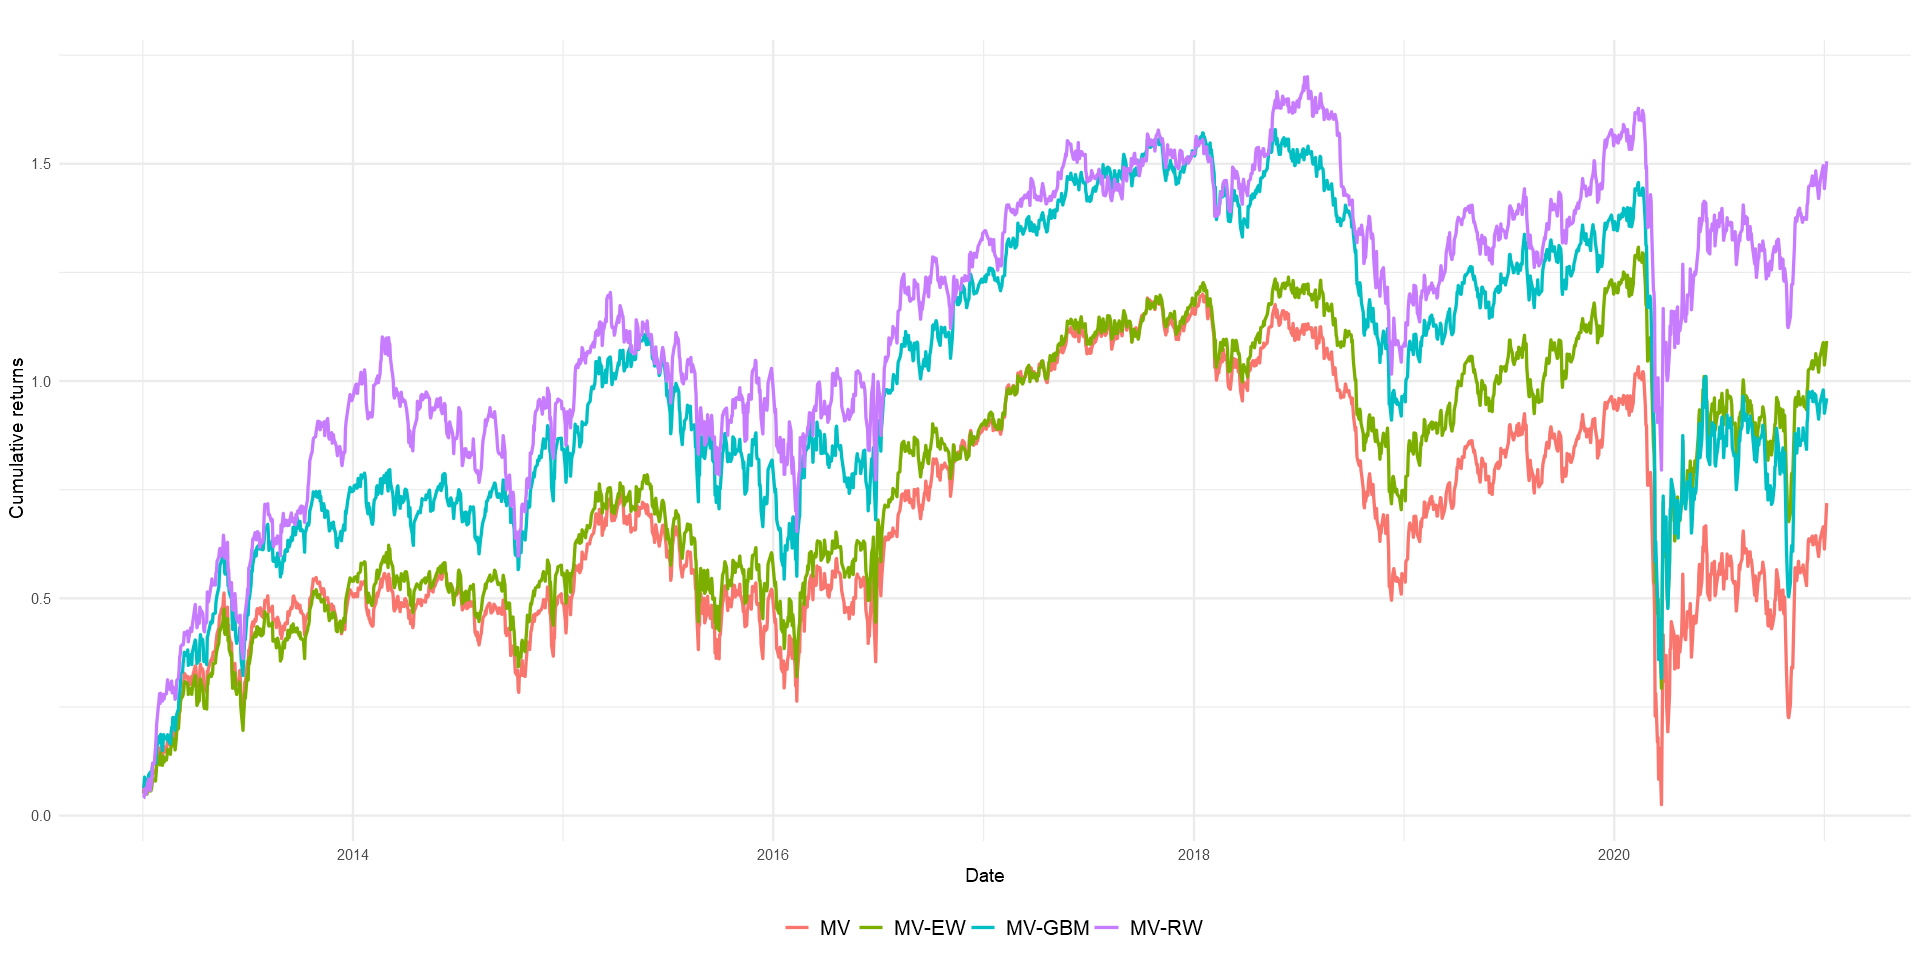

In [104]:
p0 <- ggplot(base.cum.ret , aes(x=date,y=cumulative.return,col=Modelo) )+
  geom_line(size=0.7) +
  theme_minimal() +
  theme(legend.position="bottom",
        legend.title = element_blank(),
        legend.text = element_text(colour="black", size=12)) +
  labs(title="",x='Date',y='Cumulative returns') 
p0

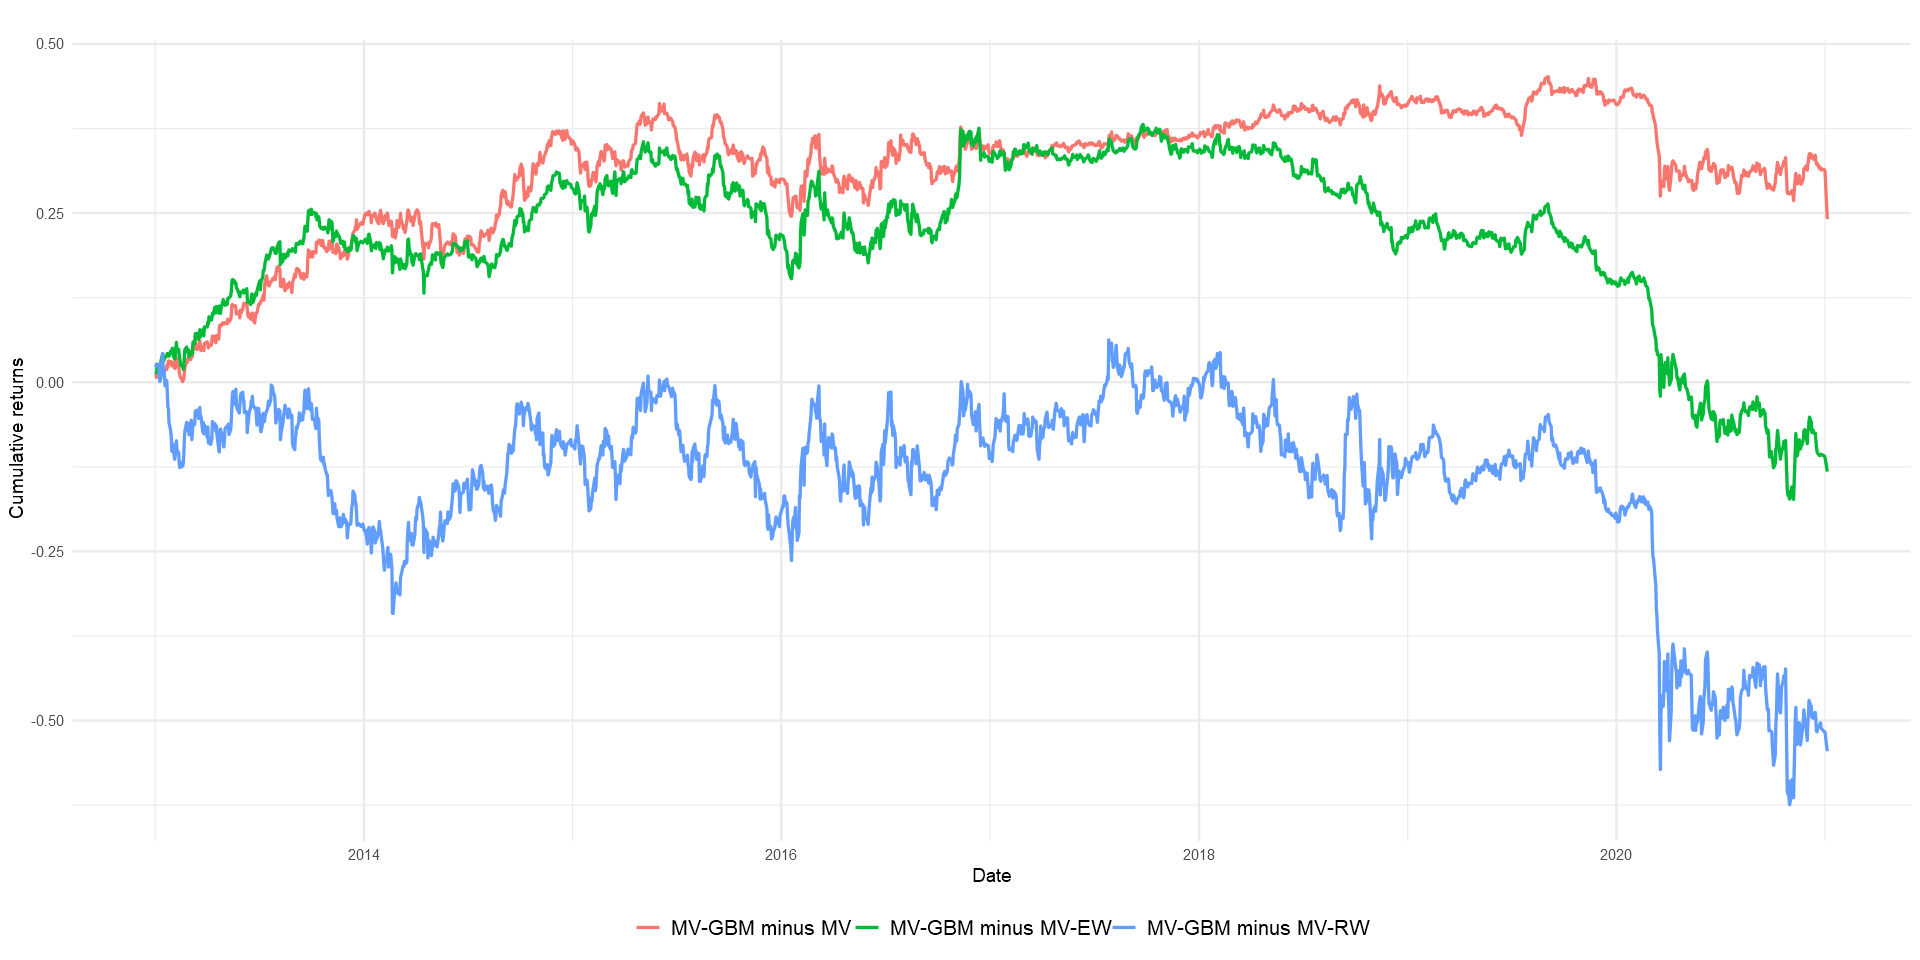

In [105]:
# differences
p1 <- ggplot(base.portfolio.diff , aes(x=date,y=cumulative.return.diff,col=Modelo) )+
  geom_line(size=0.7) +
  theme_minimal() +
  theme(legend.position="bottom",
        legend.title = element_blank(),
        legend.text = element_text(colour="black", size=12)) +
  labs(title="",x='Date',y='Cumulative returns') 
p1

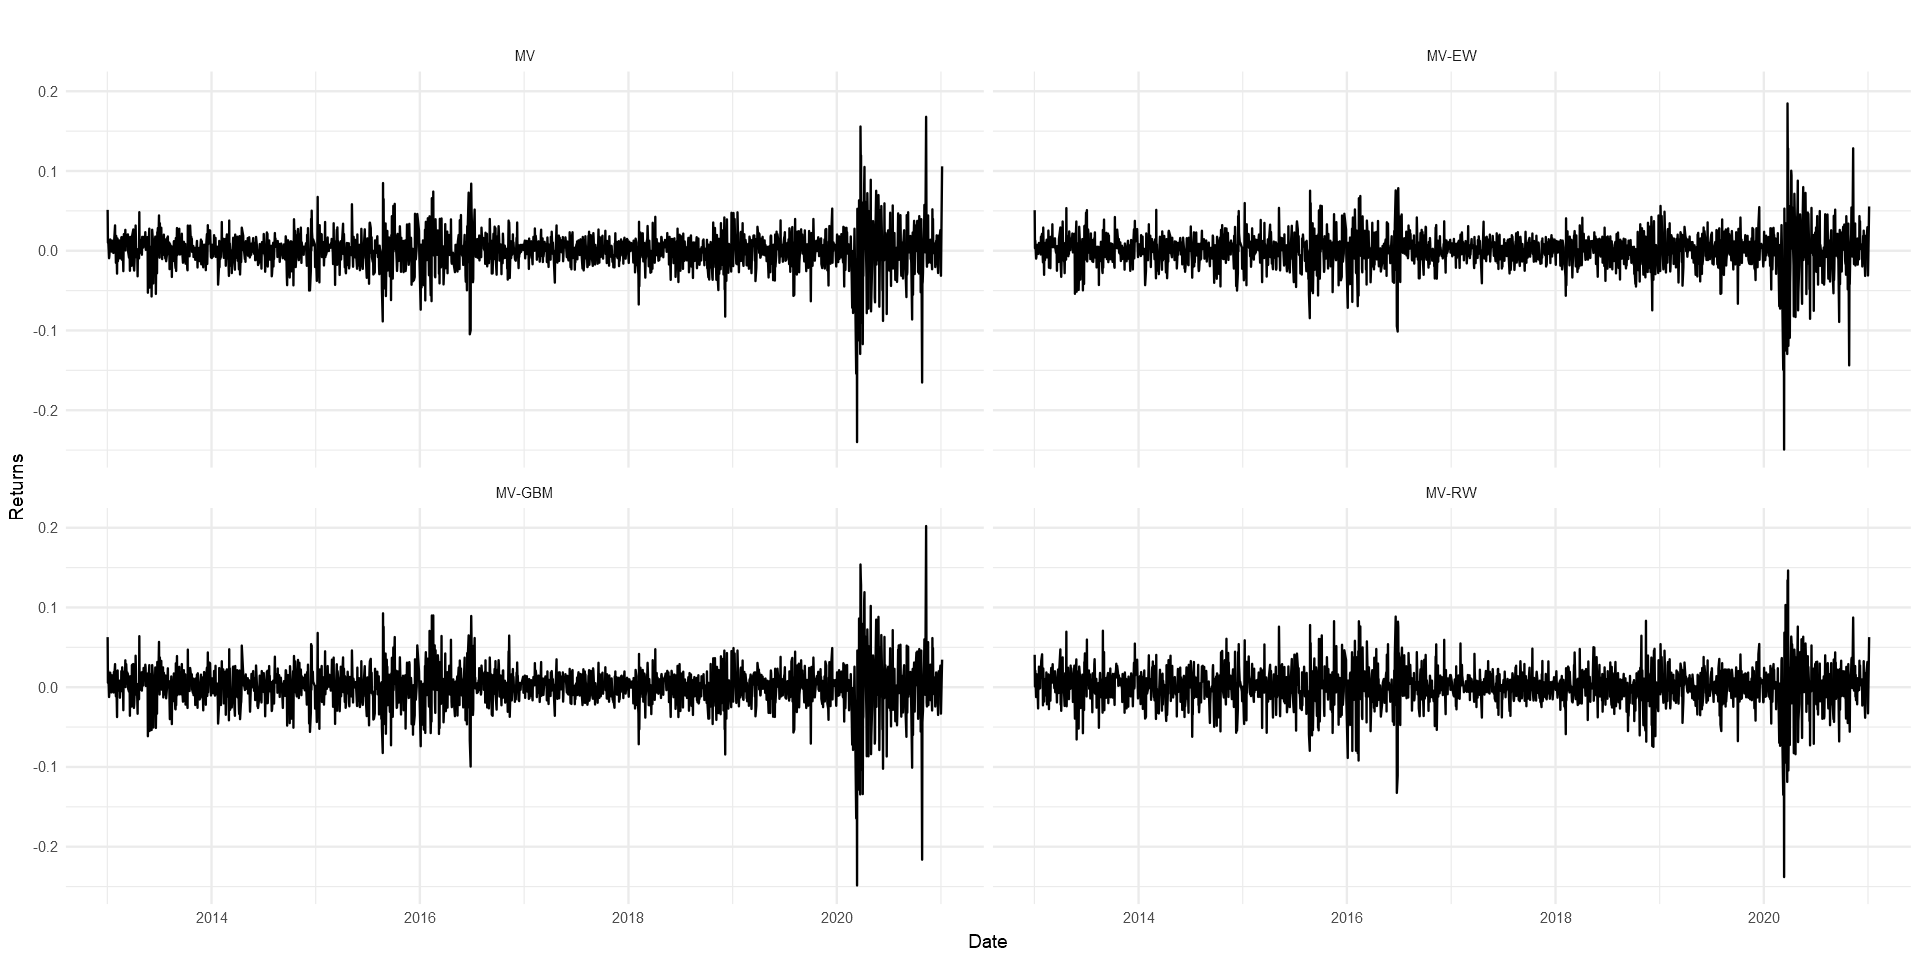

In [106]:
#  returns   
base.ret <- portfolio.ret %>%
  gather(key='Modelo',value='portfolio.return',-date)

# portfolio returns
p2 <- ggplot(base.ret , aes(x=date,y=portfolio.return) )+
  geom_line() +
  theme_minimal() +
  labs(title="",x='Date',y='Returns') +
  facet_wrap(vars(Modelo)) 
p2

In [107]:
# Global Sharpe ratio
mean_port <- base.ret %>% 
  group_by(Modelo) %>% 
  summarize(mean=mean(portfolio.return),
            sd = sd(portfolio.return),
            SharpeRatio = mean/sd) %>%
  ungroup() %>%
  data.frame() %>%
  arrange(desc(SharpeRatio))
mean_port

Modelo,mean,sd,SharpeRatio
<chr>,<dbl>,<dbl>,<dbl>
MV-RW,0.0007457826,0.02483587,0.03002844
MV-EW,0.0005410806,0.02367078,0.02285859
MV-GBM,0.0004756726,0.02624718,0.01812281
MV,0.0003562897,0.02377615,0.01498517


In [108]:
#  Sharpe Ratio df
sharpe.ratio <- portfolio.ret %>% 
  gather(key='Modelo',value='returns',-date) %>%
  mutate(year = substring(date,1,4)) %>% 
  dplyr::select(-date,Modelo,year,returns) %>%
  group_by(Modelo,year) %>%
  summarise(mean=mean(returns),sd=sd(returns)) %>%
  ungroup() %>%
  data.frame() %>%
  mutate(sharpe=mean/sd) %>%
  filter(year < '2021') 

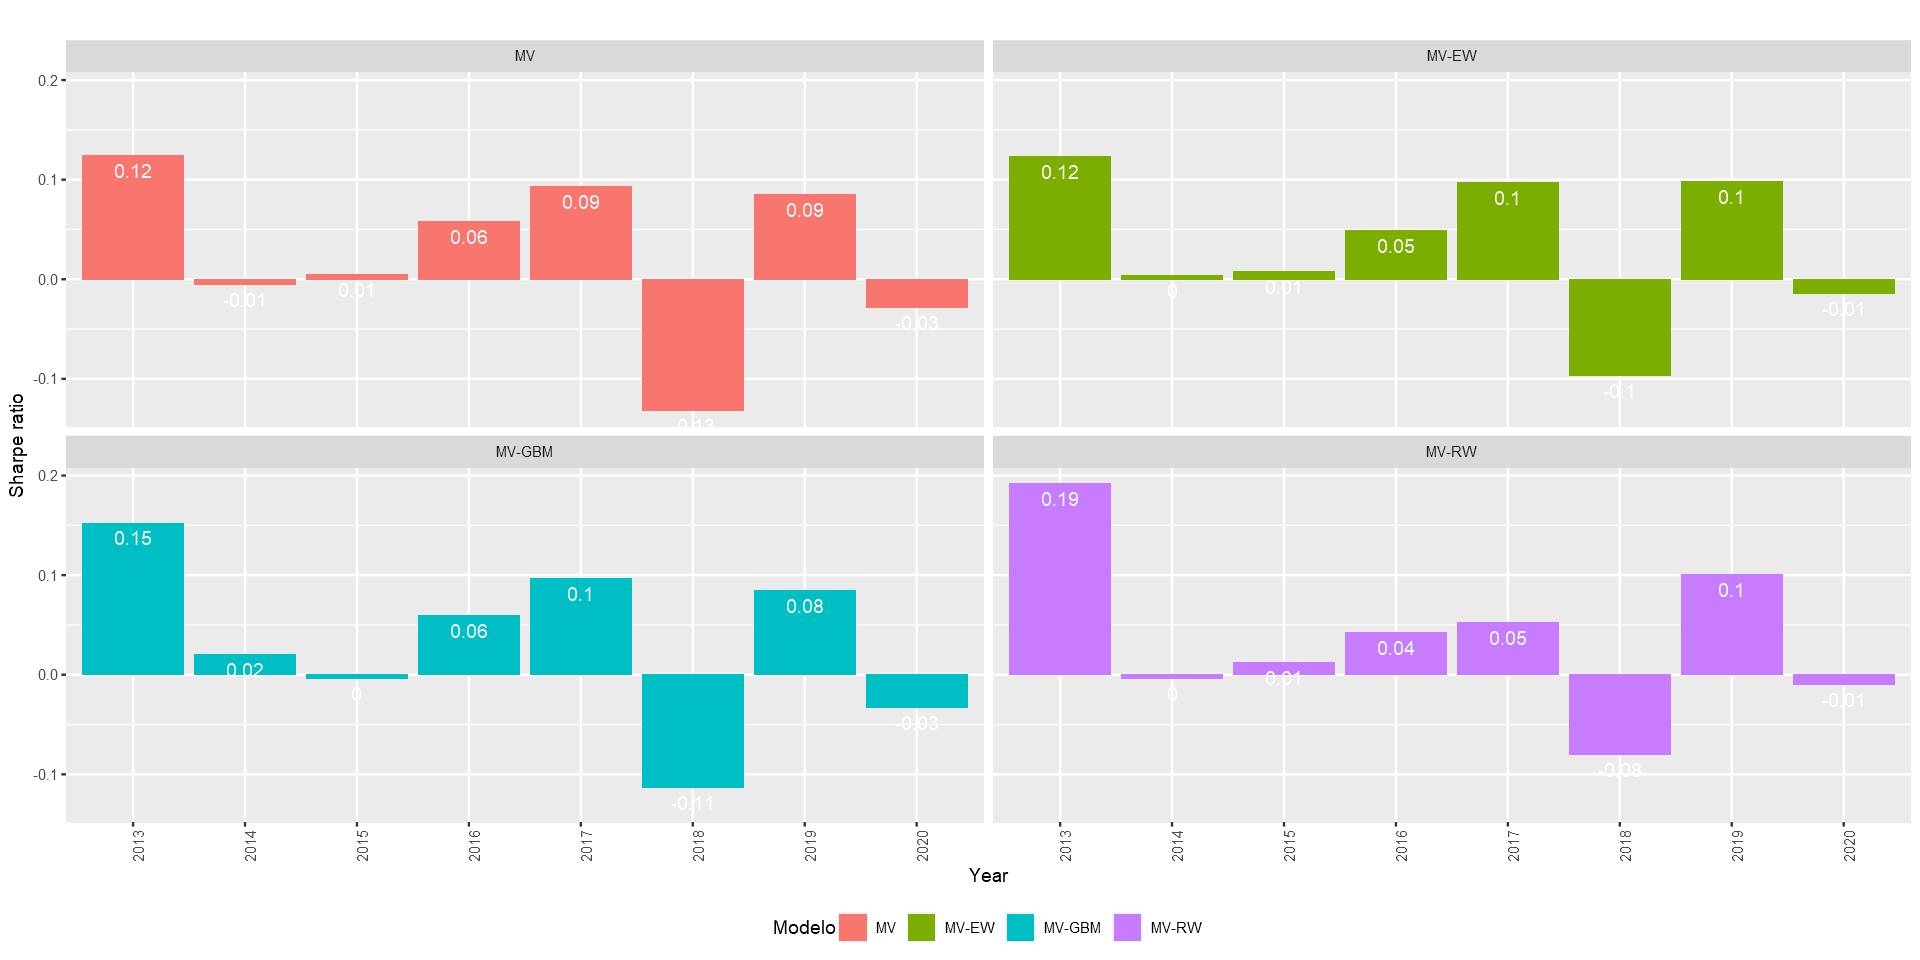

In [109]:
# Sharpe ratio plot
p4 <- ggplot(sharpe.ratio,aes(x=year,y=sharpe,fill=Modelo)) +
  geom_col(position=position_dodge()) +
  labs(title="",x='Year',y='Sharpe ratio') +
  facet_wrap(vars(Modelo)) +
  geom_text(aes(label=round(sharpe,2)), vjust=1.6, color="white", size=4) +
  theme(legend.position="bottom",
        axis.text.x = element_text(angle = 90))
  
p4

In [110]:
# Sharpe ratio table
sharpe.ratio.table <- portfolio.ret %>% 
  gather(key='Modelo',value='returns',-date) %>%
  mutate(year = substring(date,1,4)) %>%  # month = substring(date,6,7)
  dplyr::select(-date,Modelo,year,returns) %>%
  group_by(Modelo,year) %>%
  summarise(mean=mean(returns),sd=sd(returns)) %>%
  ungroup() %>%
  data.frame() %>%
  mutate(sharpe=mean/sd) %>%
  dplyr::select(-mean,-sd) %>%
  filter(year < '2021') %>%
  spread(key=Modelo,value=sharpe)
sharpe.ratio.table

year,MV,MV-EW,MV-GBM,MV-RW
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
2013,0.124027861,0.123550047,0.152355096,0.192393730
2014,-0.005596753,0.003559616,0.020484095,-0.003610784
2015,0.005030326,0.008113185,-0.003829535,0.012434836
2016,0.058060184,0.048843212,0.059632859,0.042785492
2017,0.092676401,0.097552627,0.096529191,0.052461014
2018,-0.131716794,-0.096781177,-0.113643180,-0.079984626
2019,0.085449745,0.098110952,0.084680155,0.100902612
2020,-0.028243276,-0.014337615,-0.032858545,-0.009968344


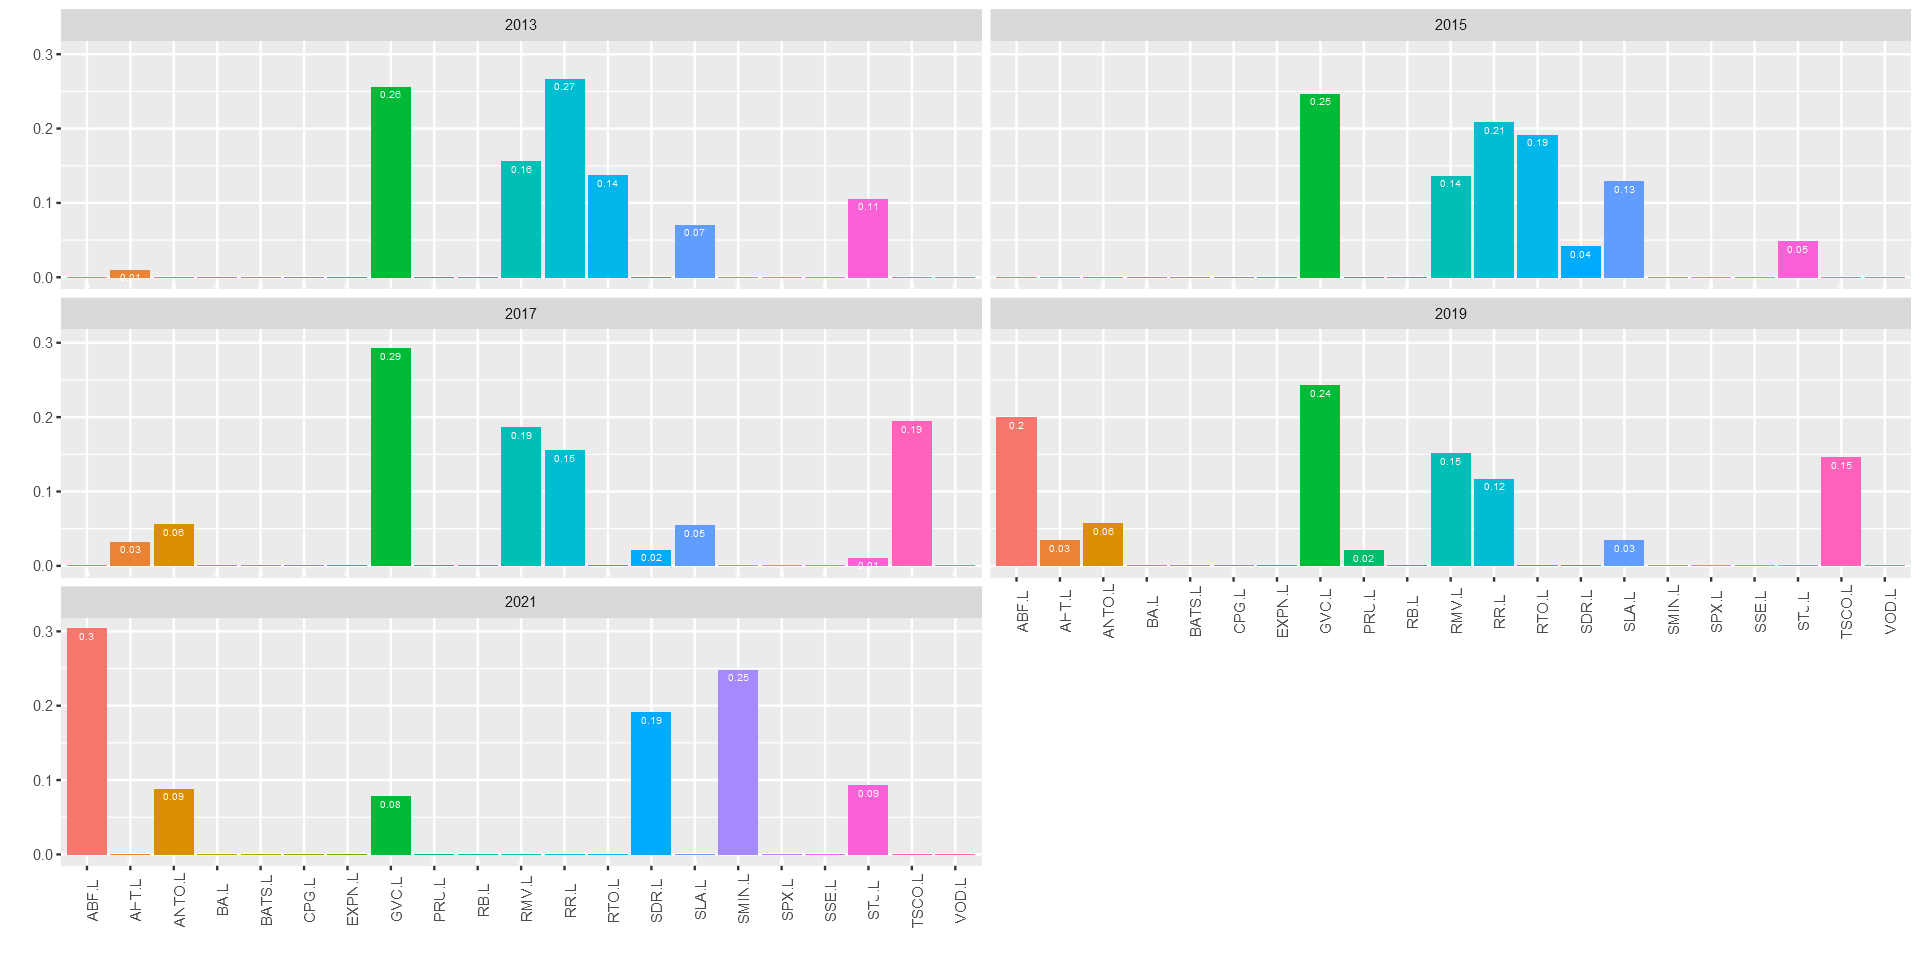

In [111]:
#  Weights
df_weights <- port.mv$df_min_weights %>%
  gather(key='asset',value='valor',-year) %>%
  mutate(year = substring(year,1,4)) 

p5 <- ggplot(df_weights,aes(x=asset,y=valor,fill=asset)) +
  geom_col(position=position_dodge()) +
  labs(x='',y='') +
  facet_wrap(vars(year),ncol=2) +
  geom_text(aes(label=round(valor,2)), vjust=1.6, color="white", size=2) +
  theme(legend.position="none",
        legend.title = element_blank(),
        axis.text.x = element_text(angle = 90))
p5

In [112]:
# weights for each rebalance period
df_weights <- port.mv$df_min_weights %>%
  gather(key='asset',value='valor',-year) %>%
  mutate(year = substring(year,1,4)) %>%
  spread(asset,valor)
df_weights

year,ABF.L,AHT.L,ANTO.L,BA.L,BATS.L,CPG.L,EXPN.L,GVC.L,PRU.L,...,RR.L,RTO.L,SDR.L,SLA.L,SMIN.L,SPX.L,SSE.L,STJ.L,TSCO.L,VOD.L
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2013,0.0000,0.0098,0.0000,0,0,0,0,0.2558,0.0000,...,0.2665,0.137,0.0000,0.0703,0.0000,0,0,0.1053,0.0000,0
2015,0.0000,0.0000,0.0000,0,0,0,0,0.2464,0.0000,...,0.2076,0.191,0.0416,0.1290,0.0000,0,0,0.0482,0.0000,0
2017,0.0000,0.0319,0.0555,0,0,0,0,0.2921,0.0000,...,0.1546,0.000,0.0211,0.0543,0.0000,0,0,0.0105,0.1940,0
2019,0.1992,0.0343,0.0568,0,0,0,0,0.2428,0.0201,...,0.1167,0.000,0.0000,0.0340,0.0000,0,0,0.0000,0.1452,0
2021,0.3034,0.0000,0.0877,0,0,0,0,0.0776,0.0000,...,0.0000,0.000,0.1910,0.0000,0.2477,0,0,0.0927,0.0000,0
